input polygon: POLYGON ((-775682.9630379686 7066450.390907976, -781492.177187642 7063392.90977657, -785772.6507716118 7056972.19940061, -788218.6356767375 7054220.466382347, -788218.6356767375 7050245.740911517, -783632.4139796268 7048411.252232669, -780574.9328482198 7045048.022988124, -778128.9479430943 7041379.045630434, -779046.1922825164 7038015.816385888, -780574.9328482198 7035569.831480763, -782715.1696402048 7034041.090915059, -781797.9253007827 7030677.8616705155, -783326.6658664861 7028231.876765387, -785772.6507716118 7026397.388086542, -786384.1469978932 7023645.655068274, -780574.9328482198 7023951.403181418, -781797.9253007827 7021505.4182762895, -783938.1620927675 7019059.433371167, -786689.8951110339 7018447.937144882, -791581.8649212853 7018447.937144882, -798002.57529724 7018753.685258022, -797391.0790709585 7016307.700352901, -793722.1017132702 7015390.456013476, -790053.1243555817 7015084.707900337, -787301.3913373153 7014473.211674055, -786384.1469978932 7012638.7

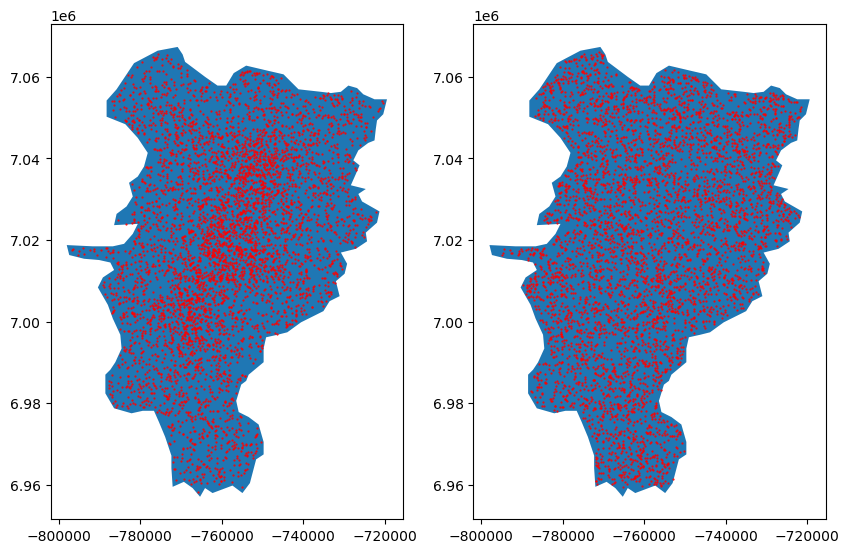

In [1]:
import geopandas as gpd
import pandas as pd
from pandas import Series
import shapely
from shapely import geometry
from shapely.ops import cascaded_union
from shapely import ops
from shapely import box, LineString, normalize, Point
import random 

from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt
import numpy as np
import time

def create_raster_grid(file_dir='scenarios/kildare/kildare.geojson',size_in_km=1, to_file=False, plot=False):
    # Create a fishnet 
    gdf = gpd.read_file(file_dir)

    # Reproject to projected coordinate system
    gdf = gdf.to_crs('EPSG:3857')
    poly = gdf['geometry'][0]
    poly_centroid = poly.centroid

    print("input polygon:", poly)

    # Get the extent of the shapefile
    total_bounds = gdf.total_bounds
 
    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
 
 
    # Determine size of buffer
    poly_width = maxX-minX
    poly_height = maxY-minY

    if poly_width > poly_height:
        buffer_size = poly_width/22
    else:
        buffer_size = poly_height/22

    print("Buffer size = ", buffer_size)

    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    square_size = size_in_km * 1000
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet_dist = gpd.GeoDataFrame({'geometry': geom_array}).set_crs('EPSG:3857')
    fishnet_dist['dist_to_centroid'] = 0
    for i in range(0, len(fishnet_dist['geometry'])):
        geom_dist = poly_centroid.distance(fishnet_dist['geometry'][i].centroid) / 1000
        fishnet_dist.loc[i, 'dist_to_centroid'] = geom_dist


    fishnet = gpd.GeoSeries(geom_array).set_crs('EPSG:3857')
    #fishnet.to_file("scenarios/kildare/kildare_fishnet.geojson")

    poly_contains = gdf['geometry'][0].contains(fishnet)
    poly_raster = fishnet[poly_contains==True]
    if to_file:
        poly_raster.to_file(f"scenarios/kildare/kildare_raster_{size_in_km}.geojson")
        fishnet_dist.to_file(f"scenarios/kildare/fishnet_distances.geojson")

    
    poly_buffer1 =  poly.buffer(-buffer_size, join_style=2)
    buffer1 = poly_buffer1.contains(poly_raster)

    poly_buffer2 =  poly_buffer1.buffer(-buffer_size, join_style=2)
    buffer2 = poly_buffer2.contains(poly_raster)

    poly_buffer3 =  poly_buffer2.buffer(-buffer_size, join_style=2)
    buffer3 = poly_buffer3.contains(poly_raster)

    raster_A = poly_raster[(buffer1==False) & (buffer2==False) & (buffer3==False)]
    raster_B = poly_raster[(buffer1==True) & (buffer2==False) & (buffer3==False)]
    raster_C = poly_raster[(buffer2==True) & (buffer3==False)]
    raster_D = poly_raster[(buffer3==True)]
    

    gdf_buffers = gpd.GeoDataFrame({'geometry': [poly_buffer1, poly_buffer2, poly_buffer3, poly]})

    if plot:
        fig, ax = plt.subplots(figsize=(10,15))

        gdf.plot(ax=ax)
        fishnet_dist.plot(ax=ax, facecolor='none', edgecolor='black')
        gdf_buffers.plot(ax=ax, facecolor='none', edgecolor='green')
        raster_A.plot(ax=ax, facecolor='green', edgecolor='black')
        raster_B.plot(ax=ax, facecolor='pink', edgecolor='black')
        raster_C.plot(ax=ax, facecolor='orange', edgecolor='black')
        raster_D.plot(ax=ax, facecolor='red', edgecolor='black')

        plt.show()
        
    multi_A = shapely.geometry.MultiPolygon(raster_A.values.tolist())
    multi_B = shapely.geometry.MultiPolygon(raster_B.values.tolist())
    multi_C = shapely.geometry.MultiPolygon(raster_C.values.tolist())
    multi_D = shapely.geometry.MultiPolygon(raster_D.values.tolist())

    multi_list = [multi_A, multi_B, multi_C, multi_D]

    gdf_rasters = gpd.GeoDataFrame(pd.DataFrame(multi_list, columns=['geometry']), geometry='geometry')

    return gdf_rasters

def multi_cdf_uniform(multipolys):
    multi_lengths = [len(multi_poly.geoms) for multi_poly in multipolys['geometry']]
    total_length = sum(multi_lengths)
    cdf = []
    for i, multipoly in enumerate(multipolys['geometry']):
        if i > 0:
            last_value = cdf[i-1]
        else:
            last_value = 0
        cdf.append(last_value + (len(multipoly.geoms) / total_length))
    
    return cdf

def random_multipoly(multipolys, uniform=True):
    if uniform:
        cdf = multi_cdf_uniform(multipolys)
        rand = random.random()
        index = cdf.index(next(x for x in cdf if x > rand), 0)
    else:
        index = random.randint(0,len(multipolys['geometry'])-1)
    
    return multipolys.iloc[index]

def uniform_points_in_polygon(polygon, num_points=50, to_list=False):
    points_list = []
    minX, minY, maxX, maxY = polygon.bounds
    while len(points_list) < num_points:
        current_point = Point([random.uniform(minX, maxX), random.uniform(minY, maxY)])
        points_list.append(current_point)

    if to_list:
        return points_list
    return gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry')

def uniform_point_in_polygon(polygon):
    minX, minY, maxX, maxY = polygon.bounds
    return Point([random.uniform(minX, maxX), random.uniform(minY, maxY)])

def points_in_raster_grid(raster_grid, total_points=5000, by_area=False):
    multipol_lens = [len(multi_poly.geoms) for multi_poly in raster_grid['geometry']]
    total_grids = np.sum(multipol_lens)
    
    
    #if total_grids > total_points:
    #    print("Number of grids exceeds number of points...quitting")
    #    return []

    points_list = []

    # Radian style generation
    for i in range(total_points):
        current_multi = random_multipoly(raster_grid, by_area)
        current_grid = current_multi['geometry'].geoms[random.randint(0, len(current_multi['geometry'].geoms)-1)]
        current_point = uniform_point_in_polygon(current_grid)
        points_list.append(current_point)
  
    grid_gdf = gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry')

    return grid_gdf

def demo_example(file_dir='scenarios/glasgow/2579.geojson', points=5000, size=1):
    kildare_original = gpd.read_file(file_dir).to_crs('EPSG:3857')
    
    raster_time_start = time.time()
    kildare_grid = create_raster_grid(file_dir,size_in_km=size, to_file=False, plot=False)
    raster_time_end = time.time()
    
    uniform_start = time.time()
    kildare_points_uniform = points_in_raster_grid(kildare_grid, points, by_area=False)
    uniform_end = time.time()

    area_start = time.time()
    kildare_points_byarea = points_in_raster_grid(kildare_grid, points, by_area=True)
    area_end = time.time()

    print("Time taken for generation:")
    print(f"\tRaster grid generation = {raster_time_end-raster_time_start}")
    print(f"\tUniform generation (excluding raster grid) = {uniform_end-uniform_start}")
    print(f"\tUniform generation (including raster grid) = {(uniform_end-uniform_start) + (raster_time_end - raster_time_start)}")
    print(f"\tBy Area generation (excluding raster grid) = {area_end-area_start}")
    print(f"\tBy Area generation (including raster grid) = {(area_end-area_start) + (raster_time_end - raster_time_start)}")

    print("Total uniform points:", len(kildare_points_uniform))
    print("Total area points:", len(kildare_points_byarea))
    fig, axs = plt.subplots(1,2, figsize=(10,8))


    for ax in axs:
        kildare_original.plot(ax=ax)
        #kildare_grid.plot(ax=ax, edgecolor='grey', cmap='viridis', alpha=0.8)

    kildare_points_uniform.plot(ax=axs[0], color='red', markersize=0.3)
    kildare_points_byarea.plot(ax=axs[1], color='red', markersize=0.3)

    plt.show()

demo_example('scenarios/kildare/kildare.geojson',5000, 1)


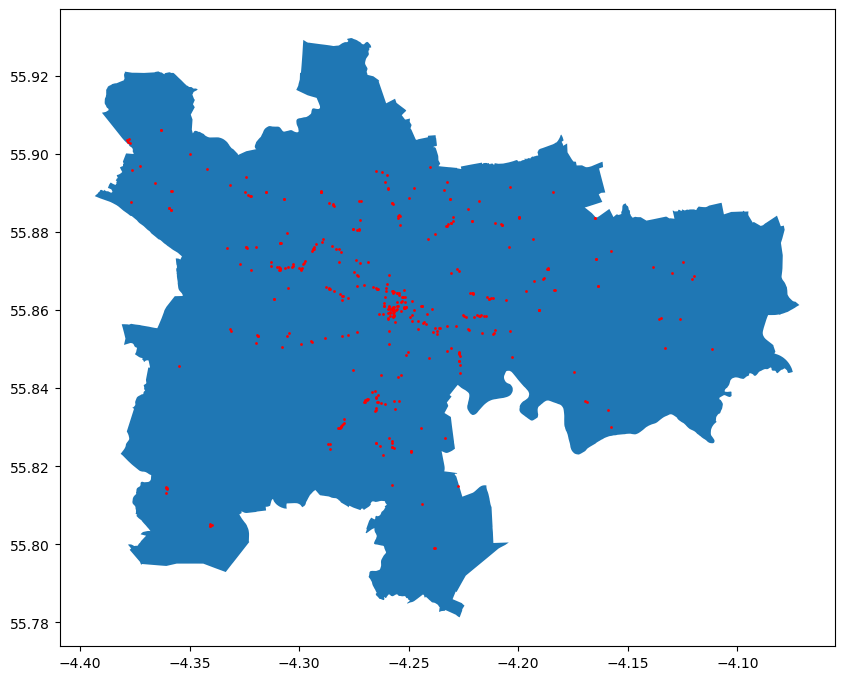

In [43]:
osm_data = gpd.read_file('scenarios/glasgow/OSM_FastFood_Glasgow_boundingbox.geojson').iloc[:, 94]
# some locations are stored as polygons describing the buildings
# we will simply them down to points (centroids)
osm_points = [geom.centroid if geom.geom_type == 'Polygon' else geom for geom in osm_data]
osm_points = gpd.GeoDataFrame(pd.DataFrame(osm_points, columns=['geometry']), geometry='geometry', crs=4326)
glasgow_bounds = gpd.read_file('scenarios/Glasgow/2579.geojson')

osm_points = osm_points.sjoin(glasgow_bounds, predicate='within')

fig, ax = plt.subplots(figsize=(10,15))

glasgow_bounds.plot(ax=ax)
osm_points.plot(ax=ax, color='red', markersize=1)

osm_points.to_file('scenarios/Glasgow/geojson/osm_fastfood_glasgow.geojson')
